In [23]:
%load_ext autoreload
%autoreload 2

from Shared.shared import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Calculating neutrino phase-space distributions.

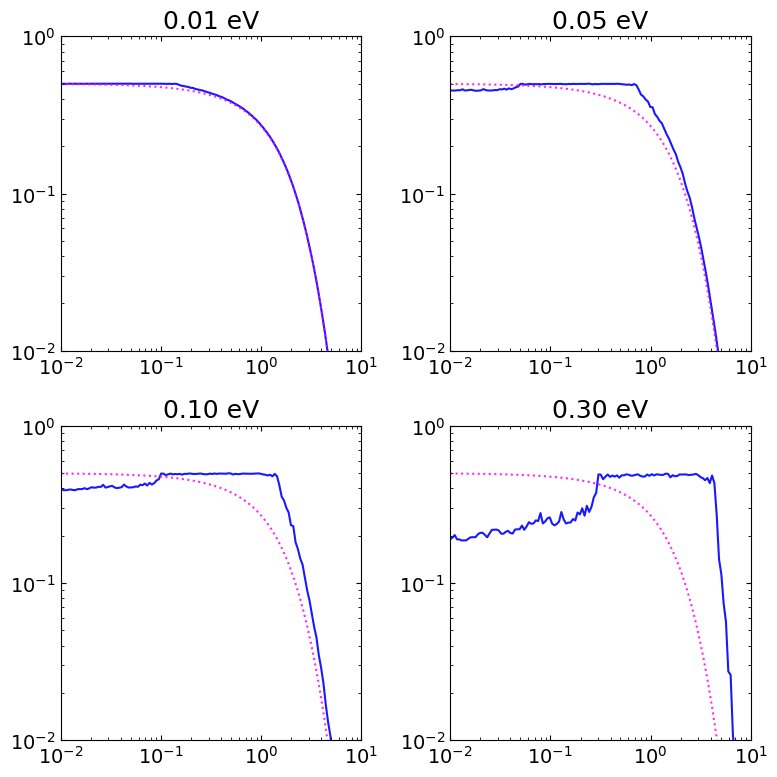

In [3]:
# Load neutrino velocities
file_name = 'neutrino_vectors_numerical_halo13'

nu_vels = jnp.array([
    jnp.load(f'Data/{file_name}_batch{i+1}.npy')[...,3:6]
    for i in range(8)
]).reshape(-1,100,3)

# Convert velocities to momenta
nu_masses = jnp.array([0.01, 0.05, 0.1, 0.3])
p_arr, y_arr = Physics.velocities_to_momenta(nu_vels, nu_masses, Params)

# Select neutrino with highest Fermi-Dirac value of each momentum batch
p_back, y_init = Physics.filter_momenta(p_arr, y_arr, len(nu_masses), Params)
p_init = y_init*Params.T_CNB

# Fermi-Dirac values
f_today = Physics.Fermi_Dirac(p_back, Params)

# Plot phase-space distribution
plt.figure()
for i, m_nu in enumerate(nu_masses):
    plt.subplot(221 + i)

    # Simulation
    plt.plot(y_init[i], f_today[i],
             label='Simulation', c='blue', alpha=0.9)

    # Original Fermi-Dirac
    p_Fermi_Dirac = jnp.geomspace(
        Params.p_start*Params.T_CNB, Params.p_stop*Params.T_CNB,
        f_today.shape[-1])
    y_Fermi_Dirac = p_Fermi_Dirac/Params.T_CNB
    f_Fermi_Dirac = Physics.Fermi_Dirac(p_Fermi_Dirac, Params)
    plt.plot(y_Fermi_Dirac, f_Fermi_Dirac,
             label='Fermi-Dirac', c='magenta', ls=':', alpha=0.85)

    plt.title(f'{m_nu:.2f} eV')
    plt.ylim(1e-2, 1e0)
    plt.xlim(Params.p_start, 1e1)
    plt.xscale('log')
    plt.yscale('log')

plt.tight_layout()
plt.show()
plt.close()

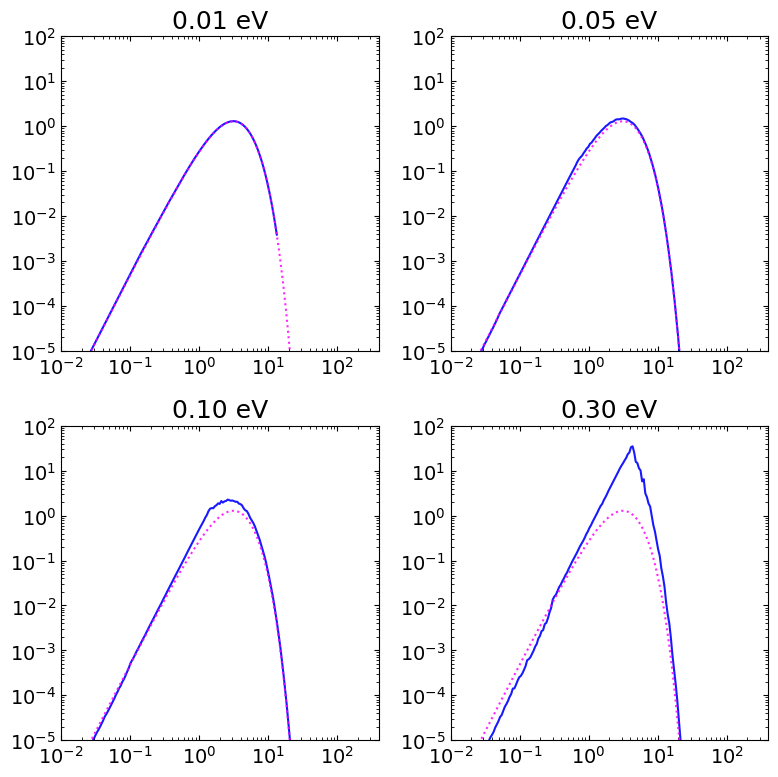

In [4]:
# Plot momentum distribution
plt.figure()
for i, m_nu in enumerate(nu_masses):
    plt.subplot(221 + i)

    # Simulation
    plt.plot(y_init[i], y_init[i]**3*f_today[i],
             label='Simulation', c='blue', alpha=0.9)

    # Original Fermi-Dirac
    p_Fermi_Dirac = jnp.geomspace(
        Params.p_start*Params.T_CNB, Params.p_stop*Params.T_CNB,
        f_today.shape[-1])
    y_Fermi_Dirac = p_Fermi_Dirac/Params.T_CNB
    f_Fermi_Dirac = Physics.Fermi_Dirac(p_Fermi_Dirac, Params)
    plt.plot(y_Fermi_Dirac, y_Fermi_Dirac**3*f_Fermi_Dirac,
             label='Fermi-Dirac', c='magenta', ls=':', alpha=0.85)

    plt.title(f'{m_nu:.2f} eV')
    plt.ylim(1e-5, 1e2)
    plt.xlim(Params.p_start, Params.p_stop)
    plt.xscale('log')
    plt.yscale('log')

plt.tight_layout()
plt.show()
plt.close()

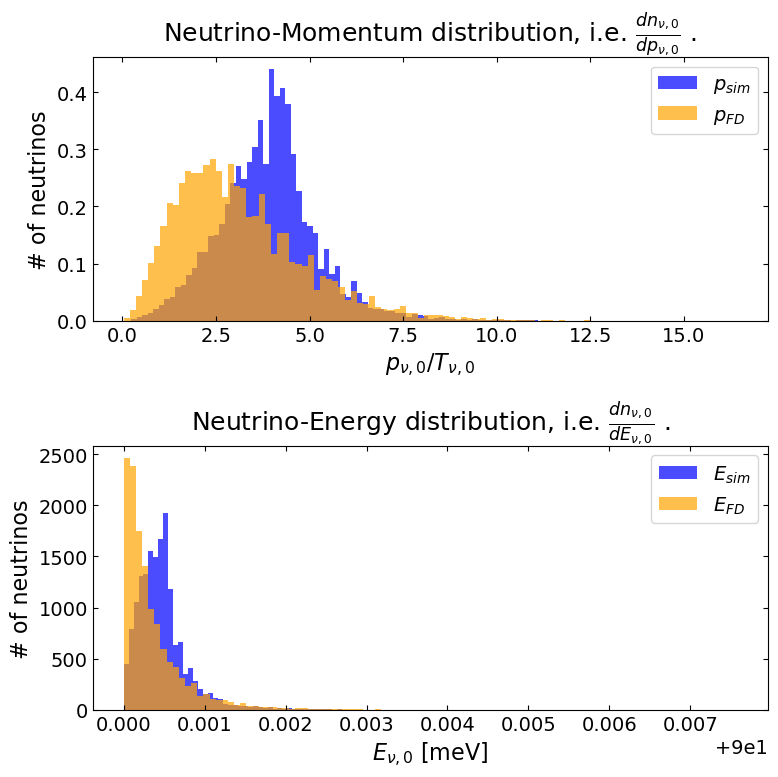

In [5]:
# Choose mass index
m_idx = -1

interpolation_type = 'cubic'

# Interpolate y_init**3*f_today = y_cubed_f
y_cubed_f = y_init[m_idx]**3*f_today[m_idx]
y_cubed_f_interp = interp1d(y_init[m_idx], y_cubed_f, kind=interpolation_type)
y_init_fine = jnp.logspace(
    jnp.log10(y_init[m_idx].min()), jnp.log10(y_init[m_idx].max()), 1000)
y_cubed_f_fine = y_cubed_f_interp(y_init_fine)

# Normalize the distribution to get a PDF
norm = jsp.integrate.trapezoid(y_cubed_f_fine, x=jnp.log10(y_init_fine))
pdf = y_cubed_f_fine / norm

# Compute the CDF
cdf = jnp.cumsum(pdf)
cdf /= cdf[-1]  # Normalize to make it a proper CDF


# The same for Fermi-Dirac distribution
p_Fermi_Dirac = jnp.geomspace(
    Params.p_start*Params.T_CNB, Params.p_stop*Params.T_CNB,
    f_today.shape[-1])
y_Fermi_Dirac = p_Fermi_Dirac/Params.T_CNB
f_Fermi_Dirac = Physics.Fermi_Dirac(p_Fermi_Dirac, Params)

y_cubed_f_Fermi_Dirac = y_Fermi_Dirac**3*f_Fermi_Dirac
y_cubed_f_interp_Fermi_Dirac = interp1d(y_Fermi_Dirac, y_cubed_f_Fermi_Dirac, kind=interpolation_type)
y_init_fine_Fermi_Dirac = jnp.logspace(
    jnp.log10(y_Fermi_Dirac.min()), jnp.log10(y_Fermi_Dirac.max()), 1000)
y_cubed_f_fine_Fermi_Dirac = y_cubed_f_interp_Fermi_Dirac(y_init_fine_Fermi_Dirac)


# Normalize the distribution to get a PDF
norm_Fermi_Dirac = jsp.integrate.trapezoid(y_cubed_f_fine_Fermi_Dirac, x=jnp.log10(y_init_fine_Fermi_Dirac))
pdf_Fermi_Dirac = y_cubed_f_fine_Fermi_Dirac / norm_Fermi_Dirac

# Compute the CDF
cdf_Fermi_Dirac = jnp.cumsum(pdf_Fermi_Dirac)
cdf_Fermi_Dirac /= cdf_Fermi_Dirac[-1]  # Normalize to make it a proper CDF


# Inverse sampling
key = jax.random.PRNGKey(0)
n_samples = 100_000
rand_uniform = jax.random.uniform(key, shape=(n_samples,))  # random numbers in [0,1]

# Find corresponding momentum values using jnp.searchsorted
sampled_indices = jnp.searchsorted(cdf, rand_uniform)
sampled_momenta = y_init_fine[sampled_indices]

sampled_indices_Fermi_Dirac = jnp.searchsorted(cdf_Fermi_Dirac, rand_uniform)
sampled_momenta_Fermi_Dirac = y_init_fine_Fermi_Dirac[sampled_indices_Fermi_Dirac]

# Convert to energies for chosen neutrino mass.
samples_energies = ((sampled_momenta*Params.T_CNB)**2 + nu_masses[m_idx]**2)/Params.meV

samples_energies_Fermi_Dirac = ((sampled_momenta_Fermi_Dirac*Params.T_CNB)**2 + nu_masses[m_idx]**2)/Params.meV


plt.figure()
labels = [r'$p_{sim}$', r'$E_{sim}$', r'$p_{FD}$', r'$E_{FD}$']
colors = ['blue', 'blue', 'orange', 'orange']
titles = [
    r'Neutrino-Momentum distribution, i.e. $\frac{d n_{\nu,0}}{d p_{\nu,0}}$ .',
    r'Neutrino-Energy distribution, i.e. $\frac{d n_{\nu,0}}{d E_{\nu,0}}$ .'
]
xlabels = [
    r'$p_{\nu,0}/T_{\nu,0}$',
    r'$E_{\nu,0}$ [meV]'
]

ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

for i, arr in enumerate([
    sampled_momenta, samples_energies,
    sampled_momenta_Fermi_Dirac, samples_energies_Fermi_Dirac]):

    if i in (0,2):
        ax1.hist(arr, bins=100, alpha=0.7, label=labels[i], color=colors[i], density=True)
        ax1.legend(loc='upper right')

        if i == 0:
            ax1.set_title(titles[i])
            ax1.set_xlabel(xlabels[i])
            ax1.set_ylabel(r'# of neutrinos')
    else:
        ax2.hist(arr, bins=100, alpha=0.7, label=labels[i], color=colors[i], density=True)
        ax2.legend(loc='upper right')

        if i == 1:
            ax2.set_title(titles[i])
            ax2.set_xlabel(xlabels[i])
            ax2.set_ylabel(r'# of neutrinos')
            
plt.tight_layout()
plt.show(); plt.close()

### **Observation:** 
There is a huge difference between 0.1 eV and 0.3 neutrinos. Almost like a threshold, which moves the whole peak of the simulation momenta/energies to the right. Before this, the Fermi-Dirac and simulation arrays mostly overlap, with the peak of the simulation even lagging behind (i.e. more on the left) a bit.

# Calculating PTOLEMY electron spectra.

## Testing Functions.

4.3691441761243686e+17 4.3478683200000006e+17
67.3968872613221 67.4


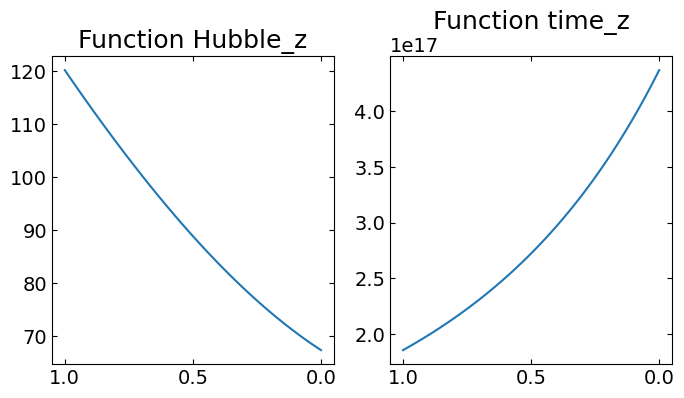

In [6]:
fig, axs = plt.subplots(1,2, figsize=(8,4))

z_range = jnp.linspace(0,1,100)
axs[0].plot(z_range, Physics.Hubble_z(z_range, Params)/(Params.km/Params.s/Params.Mpc))
axs[0].set_title('Function Hubble_z')
axs[1].plot(z_range, Physics.time_z(z_range, Params)/Params.s)
axs[1].set_title('Function time_z')
print(Physics.time_z(z_range, Params)[0]/Params.s, Params.t0/Params.s)
print(Physics.Hubble_z(z_range, Params)[0]/(Params.km/Params.s/Params.Mpc), Params.H0/(Params.km/Params.s/Params.Mpc))

for ax in axs:
    ax.invert_xaxis()

plt.show(); plt.close()

Light neutrino: 50.0 meV. Heavy neutrino: 70.80960386840194 meV
50.0 53.58835232367808


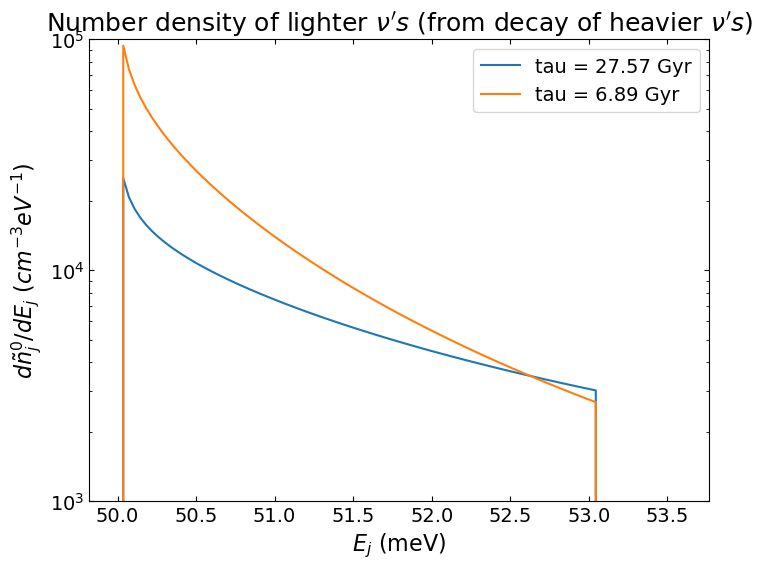

In [7]:
# Neutrino and mediator masses.
m_lightest = 50.*Params.meV
ordering = 'NO'
m_j, _, m_i = Physics.neutrino_masses(m_lightest, ordering, Params)
m_x = 0.*Params.meV
print(f'Light neutrino: {m_j/Params.meV} meV. Heavy neutrino: {m_i/Params.meV} meV')

# Energy Range for nu_1 produced by decays of nu_3 (see text above sect. 5.1.2).
E_j_lower = m_j
E_j_upper = Ptolemy.E_star(m_i, m_j, m_x)*1.01
print(E_j_lower/Params.meV, E_j_upper/Params.meV)
E_range = jnp.linspace(E_j_lower, E_j_upper, 100)
tau_i = 2*Params.t0
n0_i = 56/Params.cm**3

# X_array = jnp.linspace(-40, 80, 100)*meV  # K_e - K0_end (meV)


### Number density, energy spectrum.
fig, ax = plt.subplots(figsize=(8,6))

for tau_i in (2.*Params.t0, Params.t0/2.):
    nj_spec = jnp.array([Ptolemy.dndE_decay(E, m_j, m_i, m_x, tau_i, n0_i, Params) for E in E_range])
    nj_spec_plot = nj_spec*Params.cm**3*Params.eV
    ax.semilogy(E_range/Params.meV, nj_spec_plot, label=f'tau = {(tau_i/Params.Gyr):.2f} Gyr')

ax.set_title(r"Number density of lighter $\nu's$ (from decay of heavier $\nu's$)")
ax.set_xlabel(r'$E_j$ (meV)')
ax.set_ylabel(r'$d\tilde{n}_j^0 / dE_j$ $(cm^{-3} eV^{-1})$')
ax.set_ylim(1e3, 1e5)

plt.legend()
plt.show(); plt.close()

Max. number density n0_j: 49.27


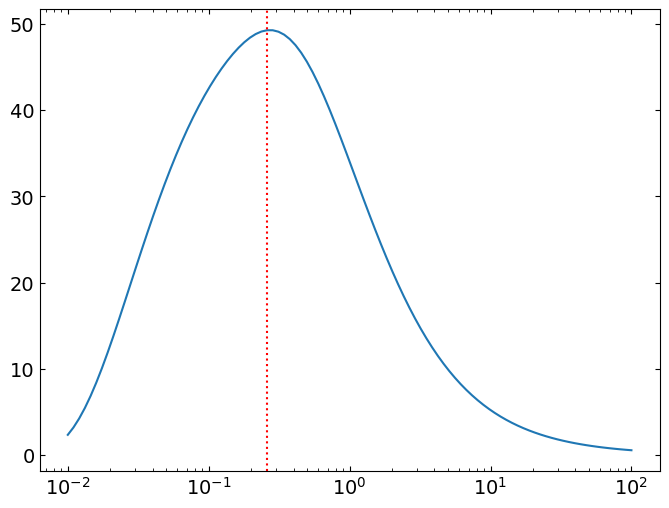

"Optimal" lifetime at 0.26 * t0 
This only happend for large enough E_lower, see comment below.


In [8]:
### Neutrino number densities today, for different decay lifetimes.
lifetimes = jnp.geomspace(1e-1, 1e3, 100)*Params.t0/10
final_n0_j = jnp.zeros(len(lifetimes))
for j, tau_i in enumerate(lifetimes):
    
    n_j_spectrum = jnp.zeros(len(E_range))
    for i, E_j in enumerate(E_range):
        jax_set_1 = Ptolemy.dndE_decay(E_j, m_j, m_i, m_x, tau_i, n0_i, Params)
        n_j_spectrum = n_j_spectrum.at[i].set(jax_set_1)

    jax_set_2 = jsp.integrate.trapezoid(n_j_spectrum, x=E_range)
    final_n0_j = final_n0_j.at[j].set(jax_set_2)


fig, ax = plt.subplots(figsize=(8,6))
lifetimes /= Params.t0
final_n0_j *= Params.cm**3
ax.semilogx(lifetimes, final_n0_j)

max_n0_j = jnp.max(final_n0_j)
print(f'Max. number density n0_j: {max_n0_j:.2f}')
ind = jnp.argwhere(final_n0_j==max_n0_j)
opt_tau = lifetimes[ind]
ax.axvline(opt_tau, ls=':', c='r')
plt.show()
print(
    f'"Optimal" lifetime at {opt_tau[0][0]:.2f} * t0 '
    '\n'
    'This only happend for large enough E_lower, see comment below.'
    )
plt.close()

## Decay spectra.

### dndE_decay spectrum

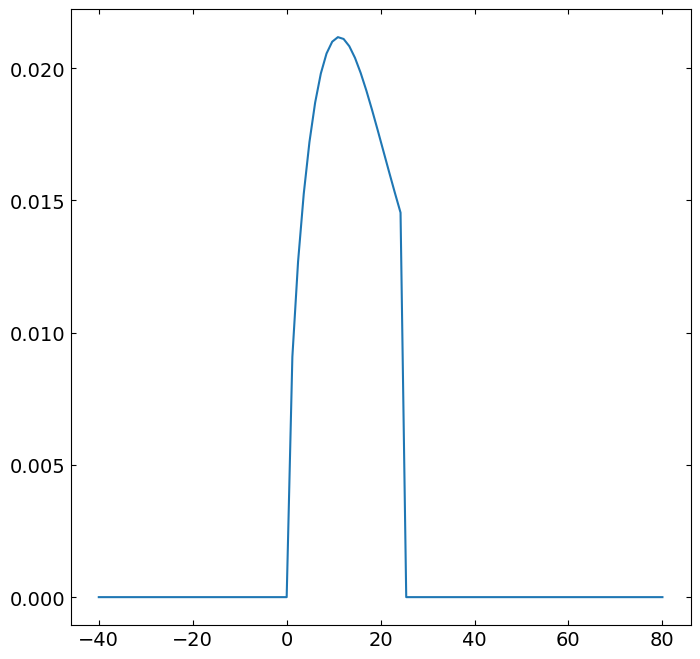

In [9]:
### Energy Range.
X_array = jnp.linspace(-40, 80, 100)*Params.meV  # K_e - K0_end (meV)
E_e_array = X_array + Params.m_e + Params.K0_end
E_j_array = Ptolemy.E_j_from_E_e(E_e_array, Params)

### Initial masses & lifetimes.
m_lightest = 0.*Params.meV
ordering = 'NO'
nu_masses = Physics.neutrino_masses(m_lightest, ordering, Params)
m_j, _, m_i = nu_masses
tau_i = 2*Params.t0
n0_i = 56/Params.cm**3
m_x = 0.*Params.meV

dnj_dEj = jnp.array([
    Ptolemy.dndE_decay(E, m_j, m_i, m_x, tau_i, n0_i, Params) for E in E_j_array])

y_axis = dnj_dEj*(Params.eV*Params.cm**2)
plt.plot(E_j_array/Params.meV, y_axis)
plt.show(); plt.close()

### Recreation of Fig. 3 of Akita et al. (2022)

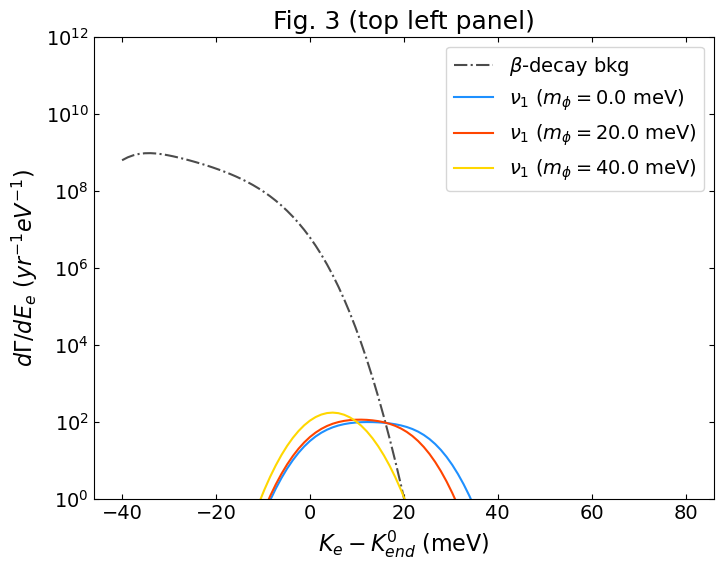

In [10]:
# note: I learned from constructing the PTOLEMY spectra, that you need to
# do proper normalizations for your convolution kernels, and to calculate the 
# spectra and convolutions for a larger "x-axis" range, and then truncate the 
# plot to the x-axis range you want to show, such that you avoid or make the
# (unphysical) edge effects of the convolution procedure invisible in the plot.

### Energy Range.
X_array = jnp.linspace(-40, 80, 100)*Params.meV  # K_e - K0_end (meV)
E_e_array = X_array + Params.m_e + Params.K0_end

### Initial masses & lifetimes.
m_lightest = 0.*Params.meV
ordering = 'NO'
nu_masses = Physics.neutrino_masses(m_lightest, ordering, Params)
m_j, _, m_i = nu_masses
tau_i = 2*Params.t0
n0_i = 56/Params.cm**3

### Original beta-decay spectrum.
beta_spec = Ptolemy.Beta_decay_spectrum(E_e_array, nu_masses, ordering, Params)

### Convolved beta-decay spectrum.
Delta = 10*Params.meV
sigma = Delta / jnp.sqrt(8*jnp.log(2))

# Normalization factor for convolution.
conv_norm = jnp.sqrt(2*Params.Pi)*sigma

convolved_beta_spec = jnp.zeros(len(E_e_array))
for i, E_e in enumerate(E_e_array):
    
    # Integration range.
    E_e_prime = E_e_array
    
    # Functions to convolve.
    f1 = Ptolemy.Beta_decay_spectrum(E_e_array, nu_masses, ordering, Params)
    g1 = jnp.exp(-(E_e - E_e_prime)**2/(2*sigma**2))

    # Convolved value at E_e.
    jax_set = jsp.integrate.trapezoid(f1*g1, x=E_e_prime) / conv_norm
    convolved_beta_spec = convolved_beta_spec.at[i].set(jax_set)


########################
### Electron spectra ###
########################

fig, ax = plt.subplots(figsize=(8,6))


#------------------------#
#-- Beta-decay spectra --#
#------------------------#

# ax.semilogy(X_array/meV, beta_spec*(yr*eV), ls=':', label='Bkg')
ax.semilogy(
    X_array/Params.meV, convolved_beta_spec*(Params.eV*Params.yr), 
    alpha=0.7, c='k', ls='-.', label=r'$\beta$-decay bkg'
)


#-------------------#
#-- Decay spectra --#
#-------------------#

# ax.semilogy(X_array/meV, decay_spec*(yr*eV), alpha=0.7, label=r'$\nu_1$ original')


# For upper panels.
mediator_masses = [0.*Params.meV, 20.*Params.meV, 40.*Params.meV]
colors = ['dodgerblue', 'orangered', 'gold']

# For lower panels.
# mediator_masses = [0.*meV]
# colors = ['dodgerblue']

for m_x, col in zip(mediator_masses, colors):

    ### Spectrum of lighter neutrinos produced by the heavier neutrino decays.
    decay_spec = Ptolemy.dGammaTilde_CNB_dE_e(
        E_e_array, m_j, m_i, m_x, tau_i, n0_i, ordering, Params)


    convolved_decay_spec = jnp.zeros(len(E_e_array))
    for i, E_e in enumerate(E_e_array):
        
        # Integration range.
        E_e_prime = E_e_array
        
        # Functions to convolve.
        f1 = Ptolemy.dGammaTilde_CNB_dE_e(
            E_e_array, m_j, m_i, m_x, tau_i, n0_i, ordering, Params)
        g1 = jnp.exp(-(E_e - E_e_prime)**2/(2*sigma**2))
 
        # Convolved value at E_e.
        jax_set = jsp.integrate.trapezoid(f1*g1, x=E_e_prime) / conv_norm
        convolved_decay_spec = convolved_decay_spec.at[i].set(jax_set)

    ax.semilogy(
        X_array/Params.meV, convolved_decay_spec*(Params.yr*Params.eV), 
        c=col, label=fr'$\nu_1$ ($m_{{\phi}}={m_x/Params.meV}$ meV)'
    )


ax.set_title(r'Fig. 3 (top left panel)')
ax.set_xlabel(r'$K_e - K_{end}^0$ (meV)')
ax.set_ylabel(r'$d\Gamma / dE_e$ $(yr^{-1} eV^{-1})$')

plt.ylim(1e0, 1e12)
plt.legend()
plt.show(); plt.close()

## Fermi-Dirac spectra.

Total nr. density (should be ~112 for one $m_\nu$ ):  112.17539237630929
Ratio of nr. density to LambdaCDM (should be ~1) 1.0014430783562205
Total nr. densities via energy integration: [112.65768669 112.66105507 112.66116168 112.66119329]
6.16e+07


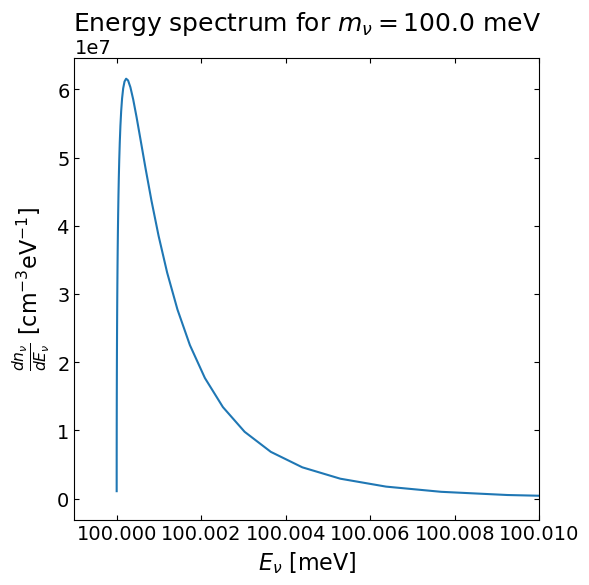

In [28]:
# Neutrino masses
masses_FD = jnp.array([10, 50, 100, 300])*Params.meV

# Momentum sampling (resolution) parameters for Fermi-Dirac spectra
p_start, p_stop, p_num = 0.01*Params.T_CNB, 100*Params.T_CNB, 100

# Energy spectrum for chosen neutrino mass
p_FD, dndp_FD, E_FD, dndE_FD, v_FD = Ptolemy.dndE_Fermi_Dirac(
    masses_FD, p_start, p_stop, p_num, Params)


v_unit = Params.km/Params.s*Params.c
# ic(v_FD.shape)
# ic(jnp.min(v_FD, axis=-1)/Params.c*100)
# ic(jnp.median(v_FD, axis=-1)/Params.c*100)

# Check if momentum distribution is normalized correctly
total_p_nr = jsp.integrate.trapezoid(dndp_FD, p_FD)
print(r'Total nr. density (should be ~112 for one $m_\nu$): ', total_p_nr*Params.cm**3)
print('Ratio of nr. density to LambdaCDM (should be ~1)', (total_p_nr*Params.cm**3)/Params.N0)

# Check if energy distribution is normalized correctly
total_E_nr = jsp.integrate.trapezoid(dndE_FD, E_FD, axis=-1)
print(f'Total nr. densities via energy integration:', total_E_nr * Params.cm**3)

plt.figure(figsize=(6,6))
m_idx = 2
print(f'{dndE_FD[m_idx].max()*(Params.eV*Params.cm**3):.2e}')
plt.title(rf'Energy spectrum for $m_\nu={masses_FD[m_idx]/Params.meV}$ meV')
plt.xlabel(r'$E_\nu$ [meV]')
plt.ylabel(r'$\frac{dn_\nu}{dE_\nu}$ [$\mathrm{cm}^{-3} \mathrm{eV}^{-1}$]')
plt.plot(E_FD[m_idx]/Params.meV, dndE_FD[m_idx]*(Params.eV*Params.cm**3))
plt.xlim(0.99999*masses_FD[m_idx]/Params.meV, masses_FD[m_idx]/Params.meV*1.0001)
# plt.ylim(1e-2,1e10)
plt.show(); plt.close()

In [33]:
# Check if integration (i.e. sum) over the rates/energies gives expected 
# results of ~4/yr and ~8/yr for Dirac and Majorana neutrinos, respectively

def events_per_year(nature, nu_masses, p_arr, args):

    pre = nature*args.U_ei_AbsSq_NO*args.sigma_avg*args.N_T

    # Compute Fermi-Dirac values
    f_arr = Physics.Fermi_Dirac(p_arr, args)

    # Compute velocities
    v_arr = 1 / jnp.sqrt(1 + (nu_masses[:,None]**2 / p_arr[None,:]**2))

    int_factor = args.g_nu / (2*args.Pi)**3
    integrand = int_factor * v_arr * f_arr

    integral = jsp.integrate.trapezoid(integrand, x=p_arr)
    return pre*integral


# Neutrino parameters
m_lightest = 10*Params.meV
ordering = 'NO'
nu_masses = Physics.neutrino_masses(m_lightest, ordering, Params)
nature = 1.

p_start, p_stop, p_num = 0.01*Params.T_CNB, 100*Params.T_CNB, 100
p_range = jnp.geomspace(p_start, p_stop, p_num)

events = events_per_year(nature, nu_masses, p_range, Params)
print(events*Params.yr)

[119633.10363891  39547.14395152    763.49868442]


## Constructing X_range

In [18]:
#
# Determine length of x-axis range based on resolution of Fermi-Dirac spectra
#

# Neutrino parameters
m_lightest = 50*Params.meV
ordering = 'NO'
nu_masses = Physics.neutrino_masses(m_lightest, ordering, Params)
nature = 1.

# Momentum sampling (resolution) parameters for Fermi-Dirac spectra
p_start, p_stop, p_num = 0.01*Params.T_CNB, 100*Params.T_CNB, 10

# Energy resolutions 
E_FD, _ = Ptolemy.dGamma_CNB_dE_e_FD(
    nu_masses, ordering, nature, p_start, p_stop, p_num, Params)
resos = jnp.abs((jnp.max(E_FD, axis=-1) - jnp.min(E_FD, axis=-1))) / (E_FD.shape[-1] - 1)

# Highest resolution of energy arrays, i.e. step size
reso = jnp.max(resos)

# Total x-axis range for spectrum, like in PTOLEMY et al. (2019) Fig. 1, 
# labeled as: E_e - E_{end,0} [meV]
X_start, X_stop = -300*Params.meV, 300*Params.meV

# Determine resolution of axis on determined step size above
X_points = int(jnp.abs((X_stop - X_start)) / reso + 1)
X_range = jnp.linspace(X_start, X_stop, X_points)

ic(X_range.shape)

ic| X_range.shape: (1975,)


(1975,)

## PTOLEMY electron spectra plots

 Fermi-Dirac (true) 
 Events per year: 2552 (sum), 496 (int)
 Fermi-Dirac (true) 
 Events per year: 3 (sum), 1 (int)
 Fermi-Dirac (true) 
 Events per year: 18 (sum), 1 (int)
 Fermi-Dirac (true) 
 Events per year: 27 (sum), 1 (int)
 Fermi-Dirac (true) 
 Events per year: 18 (sum), 1 (int)
 Fermi-Dirac (true) 
 Events per year: 27 (sum), 1 (int)
 Fermi-Dirac (true) 
 Events per year: 18 (sum), 1 (int)
 Fermi-Dirac (true) 
 Events per year: 27 (sum), 1 (int)


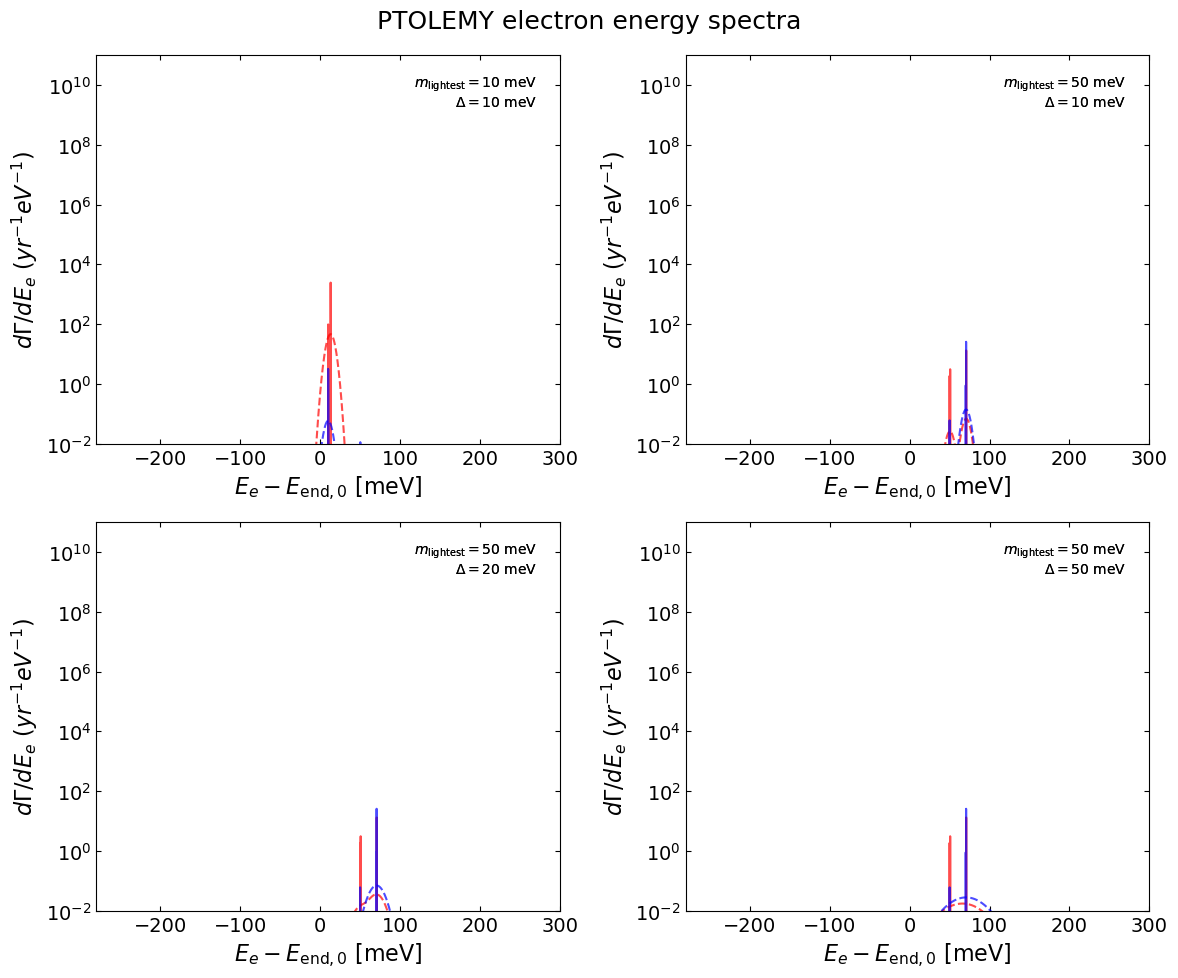

In [21]:
@jax.jit
def Gaussian_kernel(X_range, sigma, args):

    # Normalization for Gaussian
    norm = jnp.sqrt(2*args.Pi)*sigma  

    return jnp.exp(-X_range**2 / (2 * sigma**2)) / norm


@jax.jit
def Gaussian_convolution_1D(X_range, array_to_convolve, Gaussian_sigma, args):

    # X-range differences for the Gaussian in the convolution integral
    X_diff = X_range[:, None] - X_range[None, :]

    # Functions to be convolved
    f1 = array_to_convolve[:, None]
    g1 = Gaussian_kernel(X_diff, Gaussian_sigma, args)

    # Convolution by integration
    array_convolved = jsp.integrate.trapezoid(f1 * g1, x=X_range, axis=0)

    
    # # Find peak values
    # peak_original = jnp.max(array_to_convolve)
    # peak_convolved = jnp.max(array_convolved)

    # # Adjust, i.e. normalize, convolved spectrum based on peak values
    # adjustment_factor = peak_original / peak_convolved
    # array_convolved_normalized = array_convolved * adjustment_factor
    

    # # Find areas under curves
    # area_original = jsp.integrate.trapezoid(array_to_convolve, x=X_range)
    # area_convolved = jsp.integrate.trapezoid(array_convolved, x=X_range)

    # # # Adjust, i.e. normalize, convolved spectrum based on areas
    # adjustment_factor = area_original / area_convolved
    # array_convolved_normalized = array_convolved * adjustment_factor
    

    array_convolved_normalized = array_convolved

    return array_convolved_normalized


def find_n_closest(arr, value, n):
    # Absolute differences
    abs_diff = jnp.abs(arr - value)

    # Sort indices based on differences
    sorted_indices = jnp.argsort(abs_diff)

    # Use dynamic_slice to get the first n indices
    return sorted_indices[:n]


def ZhangZhang2018_overdensity(m_nu):
    return 76.5 * m_nu**2.21


def PLOT_Ptolemy_electron_spectra(spectra_list):

    # Define the set of valid spectra options
    valid_spectra = [
        "tritium_bkg_true", 
        "tritium_bkg_smeared",
        "fermi_dirac_true",
        "fermi_dirac_smeared",
        "total_true",
        "total_smeared",
        "gaussian_kernel"]

    # Helper function to get a string of valid options
    def get_valid_options_str():
        return f"Valid options: {', '.join(valid_spectra)}"

    # Check if spectra_list is empty or contains invalid items
    if not spectra_list:
        raise ValueError("spectra_list is empty. " + get_valid_options_str())
    elif any(spectrum not in valid_spectra for spectrum in spectra_list):
        raise ValueError("Invalid input in spectra_list. " + get_valid_options_str())


    # Lighest neutrino masses to anchor hierarchy
    m_lightest_arr = [10*Params.meV, 50*Params.meV]

    # PTOLEMY experiment energy resolutions
    Delta_arr = [10*Params.meV, 20*Params.meV, 50*Params.meV]

    # Explore both mass orderings
    orders = [
        'NO', 
        'IO'
    ]
    colors = ['red', 'blue']

    # Neutrino nature
    nature = 1.  # 1 = Dirac neutrinos, 2 = Majorana neutrinos

    # Momentum sampling (resolution) parameters for Fermi-Dirac spectra
    p_start, p_stop, p_num = 0.01*Params.T_CNB, 100*Params.T_CNB, 50

    # Plot 4 combinations for the parameters of the PTOLEMY experiment setup
    plt.figure(figsize=(12,10))
    for i in range(4):
        ax = plt.subplot(221 + i)

        if i == 0:  # upper left plot
            m_lightest = m_lightest_arr[0]
            Delta = Delta_arr[0]
        elif i == 1:  # upper right plot
            m_lightest = m_lightest_arr[1]
            Delta = Delta_arr[0]
        elif i == 2:  # lower left plot
            m_lightest = m_lightest_arr[1]
            Delta = Delta_arr[1]
        elif i == 3:  # lower right plot
            m_lightest = m_lightest_arr[1]
            Delta = Delta_arr[2]

        y_unit = Params.yr*Params.eV

        for ordering, color in zip(orders, colors):

            # Get neutrino masses
            nu_masses = Physics.neutrino_masses(m_lightest, ordering, Params)
            m_nu_L, m_nu_M, m_nu_H = nu_masses

            # Gaussian standard deviation
            sigma = Delta/jnp.sqrt(8*jnp.log(2))

            #
            # Determine length of x-axis range based on resolution of Fermi-Dirac spectra
            #

            # Energy resolutions 
            E_FD, _ = Ptolemy.dGamma_CNB_dE_e_FD(
                nu_masses, ordering, nature, p_start, p_stop, p_num, Params)
            resos = jnp.abs((jnp.max(E_FD, axis=-1) - jnp.min(E_FD, axis=-1))) / (E_FD.shape[-1] - 1)

            # Highest resolution of energy arrays, i.e. step size
            reso = jnp.max(resos)

            # Total x-axis range for spectrum, like in PTOLEMY et al. (2019) Fig. 1, 
            # labeled as: E_e - E_{end,0} [meV]
            X_start, X_stop = -300*Params.meV, 300*Params.meV

            # Determine resolution of axis on determined step size above
            X_points = int(jnp.abs((X_stop - X_start)) / reso + 1)
            X_range = jnp.linspace(X_start, X_stop, X_points)

            # Convert to energy range
            E_range = X_range + Params.m_e + Params.K0_end


            if ordering == "NO" and "gaussian_kernel" in spectra_list:
                Gaussian = Gaussian_kernel(X_range, sigma, Params)
                ax.semilogy(
                    (X_range/Params.meV)-150, Gaussian,
                    color='orange', ls='dashdot', alpha=0.5, label=f'Gaussian') 

                # Check if Gaussian is normalized
                # Gaussian_area = jsp.integrate.trapezoid(Gaussian, x=X_range)
                # ic(Gaussian_area)



            # =============== #
            # Tritium Spectra #
            # =============== #

            # Tritium beta-decay (background) spectrum
            T_beta_spec = Ptolemy.Beta_decay_spectrum(
                E_range, nu_masses, ordering, Params)

            # Convolved (i.e. smeared) Trititum beta-decay spectrum
            T_beta_spec_conv_norm = Gaussian_convolution_1D(
                E_range, T_beta_spec, sigma, Params)


            # =================== #
            # Fermi-Dirac Spectra #
            # =================== #

            if "fermi_dirac_true" or "fermi_dirac_smeared" or "total_smeared" in spectra_list:

                # Fermi-Dirac spectrum for neutrino masses
                E_FD, spec_FD = Ptolemy.dGamma_CNB_dE_e_FD(
                    nu_masses, ordering, nature, p_start, p_stop, p_num, Params)

                spectra_FD_true = []
                spectra_FD_conv = []
                for m_nu, Es, specs in zip(nu_masses, E_FD, spec_FD):
                    
                    # Interpolate and set values outside of energy range to zero
                    spec_FD_sync = Ptolemy.jax_interp(X_range, Es, specs)

                    # Boost by gravitational clustering and convolve
                    boost = 1 + ZhangZhang2018_overdensity(m_nu)
                    spec_FD_sync *= boost

                    if "fermi_dirac_true" in spectra_list:
                        spectra_FD_true.append(spec_FD_sync)

                    if "fermi_dirac_smeared" or "total_smeared" in spectra_list:
                        
                        spec_FD_conv_norm = Gaussian_convolution_1D(
                            X_range, spec_FD_sync, sigma, Params)
                    
                        spectra_FD_conv.append(spec_FD_conv_norm)

                spectra_FD_true = jnp.sum(jnp.array(spectra_FD_true), axis=0)
                spectra_FD_conv = jnp.sum(jnp.array(spectra_FD_conv), axis=0)

                if "fermi_dirac_true" in spectra_list:
                    ax.semilogy(
                        X_range/Params.meV, spectra_FD_true*y_unit,
                        color=color, ls='solid', alpha=0.7, label=f'{ordering}')
                    
                    # Events per year
                    events_yr_sum = jnp.sum(spectra_FD_true*y_unit)
                    events_yr_int = jsp.integrate.trapezoid(
                        spectra_FD_true*y_unit, x=X_range/Params.meV)
                    print(f'\033[1m Fermi-Dirac (true) \033[0m'
                          '\n',
                          f'Events per year: {events_yr_sum:.0f} (sum), {events_yr_int:.0f} (int)')

                if "fermi_dirac_smeared" in spectra_list:
                    ax.semilogy(
                        X_range/Params.meV, spectra_FD_conv*y_unit,
                        color=color, ls='dashed', alpha=0.7, label=f'{ordering}')


            # ========================= #
            # Plot Selection of Spectra #
            # ========================= #

            if "tritium_bkg_true" in spectra_list:
                ax.semilogy(
                    X_range/Params.meV, T_beta_spec*y_unit,
                    color=color, ls='dotted')#ls=(0, (5, 10)))
                
            if "tritium_bkg_smeared" in spectra_list:
                ax.semilogy(
                    X_range/Params.meV, T_beta_spec_conv_norm*y_unit,
                    color=color, ls='solid', alpha=0.7, label=f'{ordering}')

            if "total_smeared" in spectra_list:
                total_smeared = T_beta_spec_conv_norm + spectra_FD_conv
                ax.semilogy(
                    X_range/Params.meV, total_smeared*y_unit,
                    color=color, ls='solid', alpha=0.7, label=f'{ordering}')

            ax.text(0.95, 0.95, 
                    rf'$m_\mathrm{{lightest}}={m_lightest/Params.meV:.0f}$ meV'
                    '\n'
                    rf'$\Delta={Delta/Params.meV:.0f}$ meV',
                    fontsize=10, va='top', ha='right', 
                    transform=ax.transAxes)

            # ax.legend(loc='center left', prop={'size': 10})
            ax.set_xlabel(r'$E_e - E_{\mathrm{end},0}$ [meV]', fontsize=16)
            ax.set_ylabel(r'$d\Gamma / dE_e$ $(yr^{-1} eV^{-1})$', fontsize=16)
            ax.set_xlim(-280,300)
            # ax.set_xlim(-20,70)
            # plt.xlim(0.99*m_lightest/Params.meV, m_lightest/Params.meV*1.1)
            ax.set_ylim(1e-2, 1e11)
            
    plt.suptitle('PTOLEMY electron energy spectra')
    plt.tight_layout()
    plt.show(); plt.close()


PLOT_Ptolemy_electron_spectra(
    spectra_list=(
        # "tritium_bkg_true", 
        # "tritium_bkg_smeared",
        "fermi_dirac_true",
        "fermi_dirac_smeared",
        # "total_true",
        # "total_smeared",
        # "gaussian_kernel",
        )
    )